In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# uncomment to disable numba
#os.environ['NOJIT'] = 'true' 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import pprint
from njit_multisymbol import *
from procedures import utc_ms, load_live_config, fetch_market_specific_settings, make_get_filepath
from pure_funcs import date_to_ts2, ts_to_date_utc, tuplify, numpyize, stats_multi_to_df, fills_multi_to_df, calc_drawdowns, calc_sharpe_ratio
from numba import njit
from downloader import load_hlc_cache, prepare_multsymbol_data

using numba
using numba
using numba


In [3]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

### multi symbol backtest with lossless auto unstuck

- if a position is stuck, bot will use profits made on other markets to realize losses for the stuck position
- if multiple positions are stuck, select the stuck pos whose price action distance is the lowest
- only longs are enabled for now
- each live config's individual auto unstuck is disabled

In [4]:
# select symbols for multi symbol backtest
symbols = ['ALGOUSDT', 'BLZUSDT', 'DOGEUSDT', 'ENJUSDT', 'MATICUSDT', 'MKRUSDT', 'RLCUSDT', 'RUNEUSDT', 'SUSHIUSDT', 'THETAUSDT', 'YFIUSDT']
symbols = tuple(symbols)
lcs = [load_live_config(f"configs/live/single_symbol_optimizations/recursive_grid/{symbol}.json") for symbol in symbols]

TWE = 2.0 # WE_limi for each symbol will be TWE / len(symbols)

for i in range(len(lcs)):
    lcs[i]['long']['wallet_exposure_limit'] = TWE / len(symbols)

# convert configs to numpy matrix
live_configs = numpyize([live_config_dict_to_list_recursive_grid(lc) for lc in lcs])


In [5]:
start_date = "2019-01-01"
end_date = "now"
cache_fname = make_get_filepath("tmp/" + "_".join(symbols) + "_hlc_cache.npy")
# prepare_multsymbol_data() is computationally expensive, so use a cache
try:
    hlcs = np.load(cache_fname)
    first_ts = 0
except:
    first_ts, hlcs = await prepare_multsymbol_data(symbols, start_date, end_date)
    np.save(cache_fname, hlcs)

In [6]:
starting_balance = 10000.0
do_longs = tuplify([True for _ in range(len(symbols))])
do_shorts = tuplify([True for _ in range(len(symbols))]) # shorts are not implemented yet

mss = [fetch_market_specific_settings({'symbol': symbol, 'exchange': 'binance', 'market_type': 'futures'}) for symbol in symbols]
maker_fee = mss[0]['maker_fee']

qty_steps = tuplify([mss[i]["qty_step"] for i in range(len(symbols))])
price_steps = tuplify([mss[i]["price_step"] for i in range(len(symbols))])
min_costs = tuplify([mss[i]["min_cost"] for i in range(len(symbols))])
min_qtys = tuplify([mss[i]["min_qty"] for i in range(len(symbols))])
c_mults = tuplify([mss[i]["c_mult"] for i in range(len(symbols))])

In [7]:
hlcs_clipped = hlcs#[:,0:1200000] # to backtest on subset on data

In [8]:
# will compile JIT on the first run, then be faster on subsequent runs
sts = utc_ms()
res = backtest_multisymbol_recursive_grid(
    hlcs_clipped,
    starting_balance,
    maker_fee,
    do_longs,
    do_shorts,
    c_mults,
    symbols,
    qty_steps,
    price_steps,
    min_costs,
    min_qtys,
    live_configs,
)
print(f'time elapsed {(utc_ms() - sts) / 1000:.6f}s')
fills, stats = res

time elapsed 66.891613s


In [9]:
fdf = fills_multi_to_df(fills, symbols, c_mults)
sdf = stats_multi_to_df(stats, symbols).replace(0.0, np.nan)
n_days = (sdf.index[-1] - sdf.index[0]) / 60 / 24
drawdowns = calc_drawdowns(sdf.equity)
adgb = ((sdf.balance.iloc[-1] / sdf.balance.iloc[0]) ** (1 / n_days) - 1)
adge = ((sdf.equity.iloc[-1] / sdf.equity.iloc[0]) ** (1 / n_days) - 1)
print(f'adg balance {adgb:.5f} per exposure {adgb / TWE:.5f}')
print(f'adg equity {adge:.5f} per exposure {adge / TWE:.5f}')
print(f'max drawdown {abs(drawdowns.min()):.5f}')
print('n_days', n_days)

adg balance 0.00366 per exposure 0.00183
adg equity 0.00365 per exposure 0.00182
max drawdown 0.25836
n_days 1259.6666666666667


In [10]:
fdf

,symbol,pnl,fee_paid,balance,equity,qty,price,psize,pprice,type,close_cost,WE
minute,,,,,,,,,,,,
2,THETAUSDT,0.00000,-0.004591376,9999.9954086240,9999.9954086240,53.6,0.42830,53.6,0.42830,long_ientry_normal,22.95688,0.0022956891
6,THETAUSDT,0.15544,-0.004622464,10000.1462261600,10000.5482261600,-53.6,0.43120,0.0,0.00000,long_nclose,23.11232,0.0000000000
7,THETAUSDT,0.00000,-0.004593332,10000.1416328280,10000.1416328280,52.7,0.43580,52.7,0.43580,long_ientry_normal,22.96666,0.0022966335
8,THETAUSDT,0.15810,-0.004624952,10000.2951078760,10000.5691478760,-52.7,0.43880,0.0,0.00000,long_nclose,23.12476,0.0000000000
9,THETAUSDT,0.00000,-0.004595220,10000.2905126560,10000.2905126560,52.1,0.44100,52.1,0.44100,long_ientry_normal,22.97610,0.0022975433
...,...,...,...,...,...,...,...,...,...,...,...,...
1813810,ALGOUSDT,0.00000,-0.594630048,991182.1275364272,983913.9809364273,24093.6,0.12340,24093.6,0.12340,long_ientry_normal,2973.15024,0.0029996003
1813817,RLCUSDT,0.00000,-0.586501938,991181.5410344892,983925.1593944891,2385.9,1.22910,2385.9,1.22910,long_ientry_normal,2932.50969,0.0029586000
1813826,SUSHIUSDT,13.65300,-0.587200360,991194.6068341292,984043.9376541292,-3034.0,0.96770,0.0,0.00000,long_nclose,2936.00180,0.0000000000


In [11]:
sdf

,balance,equity,ALGOUSDT_psize_l,ALGOUSDT_pprice_l,ALGOUSDT_psize_s,ALGOUSDT_pprice_s,ALGOUSDT_price,BLZUSDT_psize_l,BLZUSDT_pprice_l,BLZUSDT_psize_s,...,BLZUSDT_WE,DOGEUSDT_WE,ENJUSDT_WE,MATICUSDT_WE,MKRUSDT_WE,RLCUSDT_WE,RUNEUSDT_WE,SUSHIUSDT_WE,THETAUSDT_WE,YFIUSDT_WE
minute,,,,,,,,,,,,,,,,,,,,,
0,10000.0000000000,10000.0000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,10000.2859202320,9999.8417002320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0045936907,NaN
120,10000.2859202320,9999.7888002320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0045936907,NaN
180,10001.4933263920,9998.2498663920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0120173044,NaN
240,10004.3527126100,10004.2683926100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0022956668,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813680,990852.1675798571,983757.6014598571,69034.2,0.1228374606,NaN,NaN,0.1239,39631.0,0.2725364889,NaN,...,0.0109006105,0.0048538123,NaN,NaN,0.0168937594,NaN,NaN,0.0029487164,0.0022925828,0.0021600316
1813740,991183.3066362352,984170.1714362352,NaN,NaN,NaN,NaN,0.1249,NaN,NaN,NaN,...,NaN,0.0048521907,NaN,NaN,0.0168881154,NaN,NaN,NaN,0.0022918169,0.0021628936
1813800,991183.3066362352,984059.5694362352,NaN,NaN,NaN,NaN,0.1245,NaN,NaN,NaN,...,NaN,0.0048521907,NaN,NaN,0.0168881154,NaN,NaN,NaN,0.0022918169,0.0021628936


<AxesSubplot:xlabel='minute'>

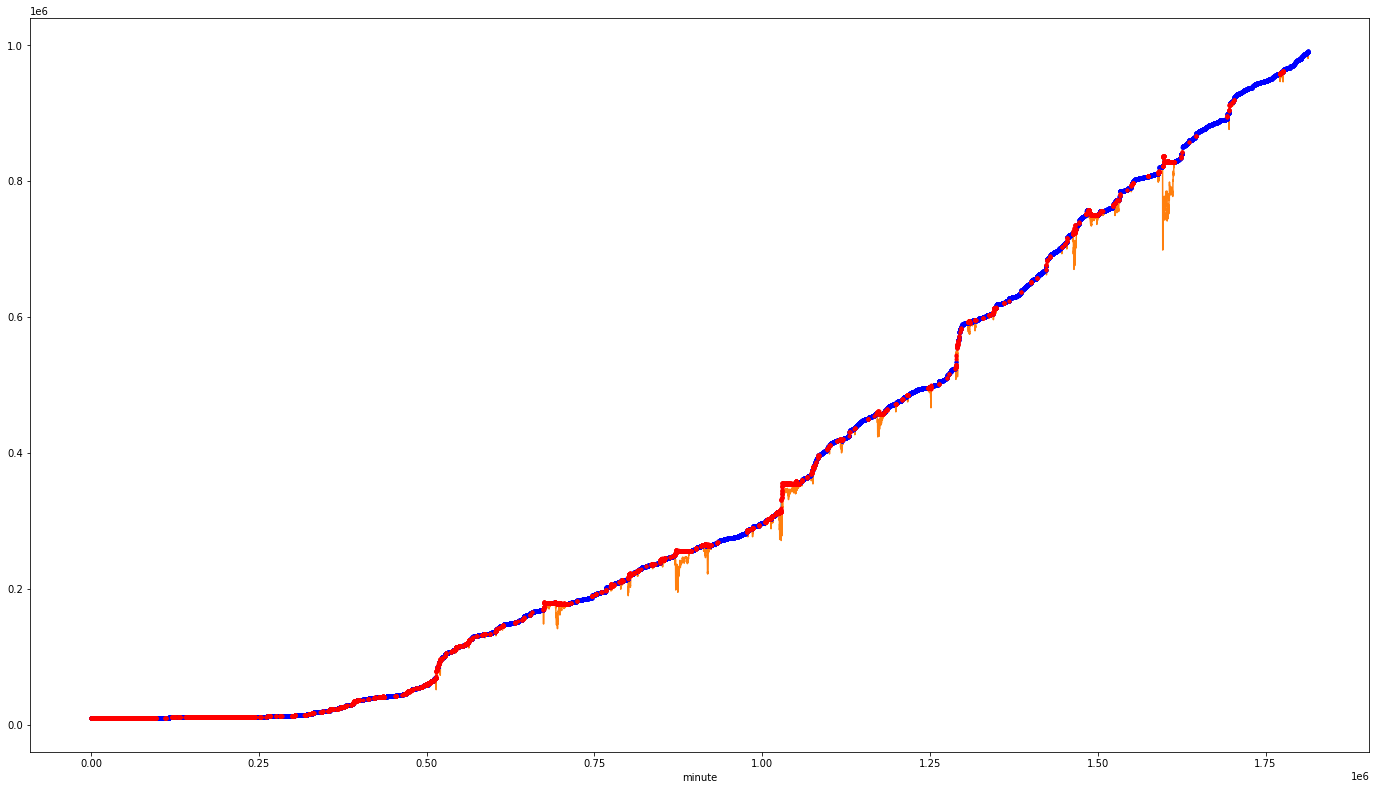

In [12]:
# stuckness is defined as wallet_exposure / wallet_exposure_limit > 0.9
# red dots when there are any positions stuck
# blue dots when there are no positions stuck
any_stuck = (sdf[[c for c in sdf.columns if "WE" in c]] > (TWE / len(symbols)) * 0.9).any(axis=1)
sdf.balance.plot()
sdf.equity.plot()
sdf[~any_stuck].balance.plot(style='b.')
sdf[any_stuck].balance.plot(style='r.')

<AxesSubplot:xlabel='minute'>

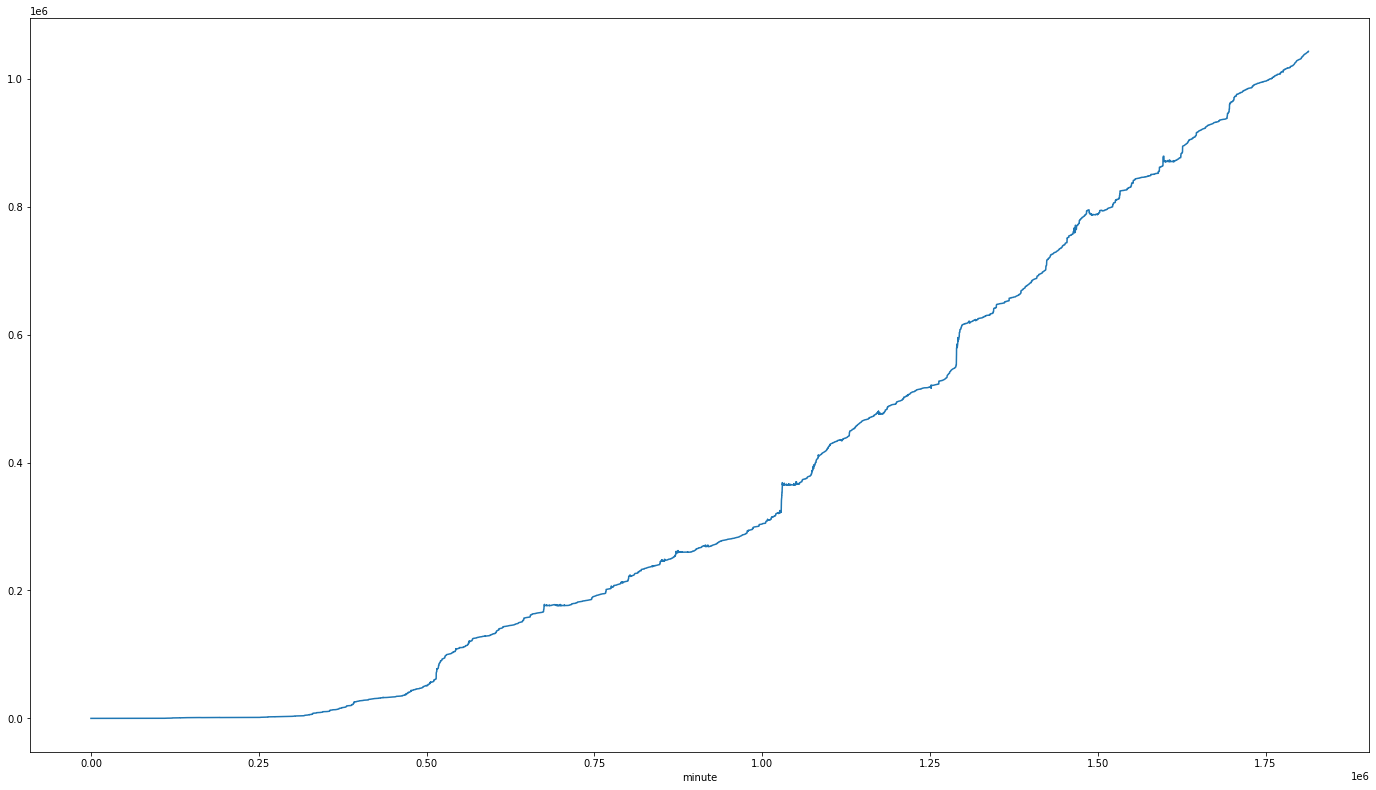

In [13]:
fdf.pnl.cumsum().plot()

In [14]:
# inspect pnl sum for each symbol
fdf.groupby(fdf.symbol).pnl.sum()

symbol
ALGOUSDT     107353.2109445866
BLZUSDT       61239.7411048626
DOGEUSDT     163432.8971716803
ENJUSDT       88777.4829085110
MATICUSDT    155557.2727399938
MKRUSDT      101833.4432527829
RLCUSDT      113607.6518170647
RUNEUSDT      73187.8524526183
SUSHIUSDT     61089.4319272454
THETAUSDT     37648.9248032523
YFIUSDT       79515.4194298069
Name: pnl, dtype: float64

In [15]:
# inspect loss sum for each symbol
fdf[fdf.pnl < 0.0].groupby('symbol').pnl.sum()

symbol
ALGOUSDT     -9164.7892471864
BLZUSDT      -5878.6683689860
DOGEUSDT    -41191.8785816474
ENJUSDT      -4410.9794500913
MATICUSDT   -20320.6539585585
MKRUSDT      -7481.9470392142
RLCUSDT     -44228.1599511586
RUNEUSDT    -17922.9286684065
SUSHIUSDT   -24001.7614808322
THETAUSDT   -39499.1054212543
YFIUSDT     -26650.2543237993
Name: pnl, dtype: float64

In [16]:
# greatest pct unstuck close
fdfr = fdf.reset_index()
unstucks = fdfr[fdfr.type.str.contains("unstuck")]
idx = (unstucks.pnl / unstucks.balance).idxmin()
print(unstucks.loc[idx])
idx = unstucks.loc[idx].name
print(idx)
fdfr.iloc[idx-10:idx+10]

minute                    191804
symbol                 SUSHIUSDT
pnl              -163.1206165193
fee_paid            -0.020580753
balance         11162.0255111523
equity           9894.0612556762
qty                       -165.0
price               0.6236591821
psize                     1111.0
pprice              1.6122689792
type          unstuck_close_long
close_cost        102.9037650509
WE                  0.1604754293
Name: 12780, dtype: object
12780


,minute,symbol,pnl,fee_paid,balance,equity,qty,price,psize,pprice,type,close_cost,WE
12770,191770,THETAUSDT,0.1748400000,-0.005231064,11324.5121151446,10044.2231966685,-37.200,0.7031000000,0.000,0.0000000000,long_nclose,26.1553200000,0.0000000000
12771,191771,THETAUSDT,0.0000000000,-0.005199948,11324.5069151966,10044.5011077205,36.900,0.7046000000,36.900,0.7046000000,long_ientry_normal,25.9997400000,0.0022958827
12772,191774,MKRUSDT,0.2286600000,-0.007733000,11324.7278421966,10055.4756207205,-0.074,522.5000000000,0.000,0.0000000000,long_nclose,38.6650000000,0.0000000000
12773,191775,MKRUSDT,0.0000000000,-0.007636238,11324.7202059586,10054.7081214825,0.073,523.0300000000,0.073,523.0300000000,long_ientry_normal,38.1811900000,0.0033714908
12774,191775,YFIUSDT,0.1264000000,-0.006158800,11324.8404471586,10054.8152226825,-0.002,15397.0000000000,0.000,0.0000000000,long_nclose,30.7940000000,0.0000000000
12775,191776,YFIUSDT,0.0000000000,-0.006153440,11324.8342937186,10054.6330262425,0.002,15383.6000000000,0.002,15383.6000000000,long_ientry_normal,30.7672000000,0.0027167903
12776,191777,THETAUSDT,0.1771200000,-0.005235372,11325.0061783466,10052.1130338705,-36.900,0.7094000000,0.000,0.0000000000,long_nclose,26.1768600000,0.0000000000
12777,191778,THETAUSDT,0.0000000000,-0.005196720,11325.0009816266,10049.0010951505,36.700,0.7080000000,36.700,0.7080000000,long_ientry_normal,25.9836000000,0.0022943574
12778,191788,THETAUSDT,0.1761600000,-0.005231952,11325.1719096746,10047.4581661985,-36.700,0.7128000000,0.000,0.0000000000,long_nclose,26.1597600000,0.0000000000
12779,191789,THETAUSDT,0.0000000000,-0.005201250,11325.1667084246,10046.8863749485,36.500,0.7125000000,36.500,0.7125000000,long_ientry_normal,26.0062500000,0.0022963238


In [17]:
# split fdf into symbols
fs = [fdf[fdf.symbol == symbol] for symbol in symbols]

6 RLCUSDT


<AxesSubplot:xlabel='minute'>

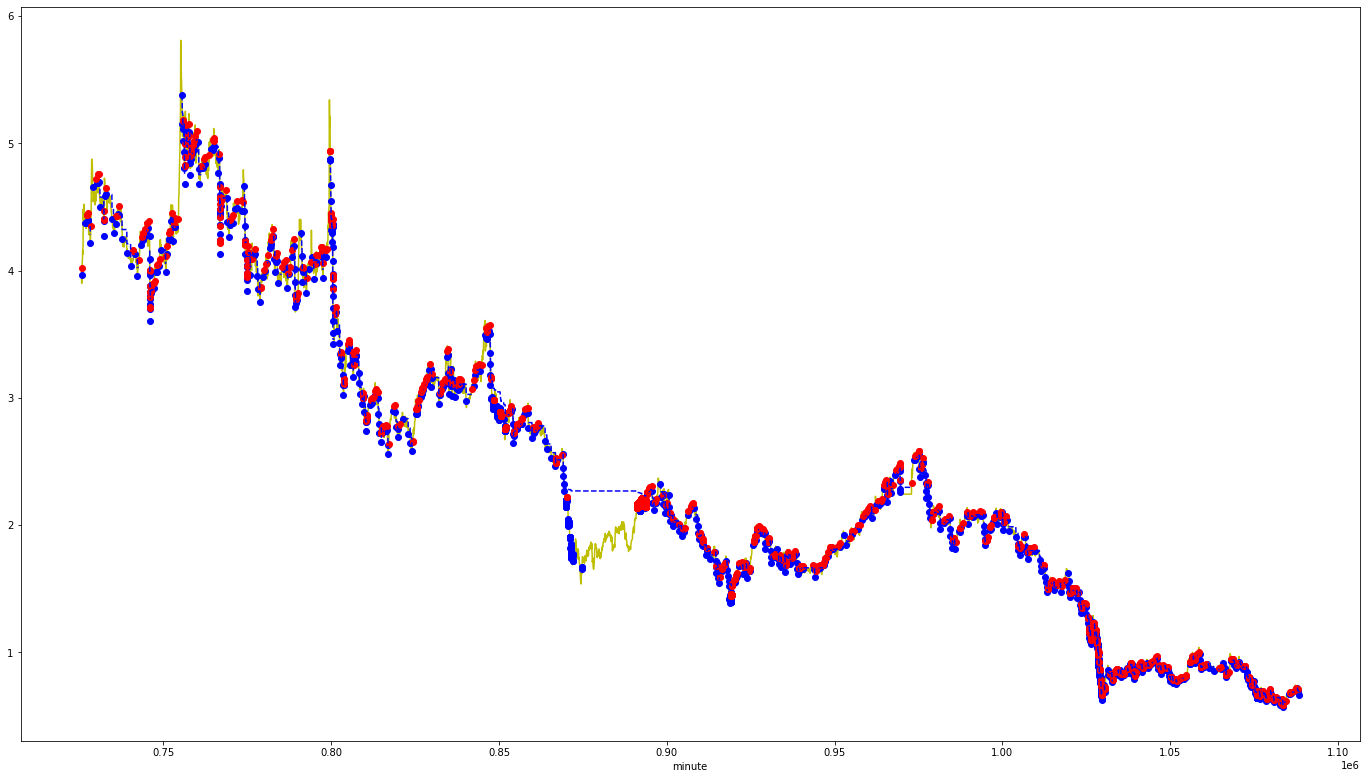

In [18]:
# select a symbol by index or symbol name
i = 6
#symbol = "THETAUSDT"
#i = symbols.index(symbol)
print(i, symbols[i])

# if start_pct==0.4 and end_pct==0.6, plot from 40% to 60%
start_pct = 0.4
end_pct = 0.6
start_minute = int(sdf.index[-1] * start_pct)
end_minute = int(sdf.index[-1] * end_pct)
sdfc = sdf.loc[start_minute:end_minute]
sdfc[f"{symbols[i]}_price"].plot(style='y')
buys = fs[i][fs[i].type.str.contains('entry')]
buys = buys.loc[start_minute:end_minute]
sells = fs[i][fs[i].type.str.contains('close')]
sells = sells.loc[start_minute:end_minute]
buys.price.plot(style='bo')
sells.price.plot(style='ro')
sdfc[f"{symbols[i]}_pprice_l"].replace(0.0, np.nan).plot(style='b--')

<AxesSubplot:xlabel='minute'>

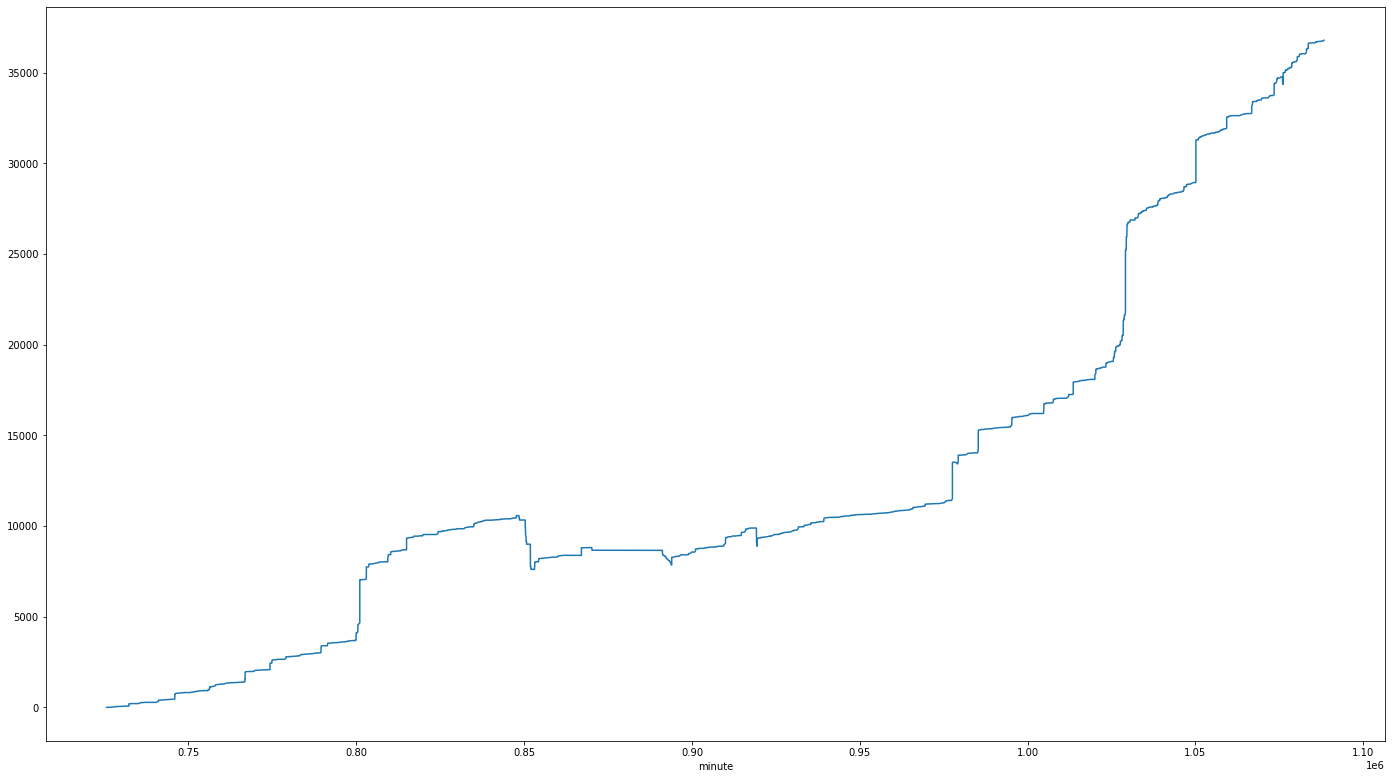

In [19]:
fs[i].loc[start_minute:end_minute].pnl.cumsum().plot()